<a href="https://colab.research.google.com/github/sanjoy-kumar/Practical-Machine-Learning-Labs/blob/main/ArabicTestClassificationCNNwithGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries Import**
---------------------


In [ ]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
plt.switch_backend('agg')
%matplotlib inline

**Define Constant Value**
------------------------



In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
filter_sizes = [3, 5, 7]
BATCH_SIZES = [1000, 250,500,100]
EPOCHS_VALUES = [10,15,20,30,40,50,60]
OPTIMIZERS_VALUES = ['rmsprop','adam','Adadelta']

**Load the Data**
----------------


Two Datasets in CSV format: 1. SNAD Dataset 2. MNAD Dataset
Due to size, it is not possible to upload GitHub site. Please visit the following links to collect Datasets. Please change the file location accoding to your data file location.


For SNAD and MNAD Dataset: https://drive.google.com/drive/folders/1RMv8ExcUgoTCU3OX2fjUxp-1_rkD-w9H?usp=sharing



In [ ]:
#----------------- Reading SNAD data --------------------------- 
df=pd.read_csv('/content/drive/MyDrive/ArabicTextData/SNAD.csv');

# --------------- Reading MNAD data------------------------------- 
#df=pd.read_csv('/content/drive/MyDrive/ArabicTextData/MNAD.csv');

df

,title,url,targe,text
0,برعاية خادم الحرمين الشريفين.. انطلاق أعمال ند...,spa,5,وبدء الحفل المعد بهذه المناسبه بايات من القران...
1,برعاية خادم الحرمين الشريفين.. انطلاق أعمال ند...,spa,5,وانطلقت اعمال الندوه التي تقام بمركز الملك سلم...
2,برعاية خادم الحرمين الشريفين.. انطلاق أعمال ند...,spa,5,وانطلقت اعمال الندوه التي تقام بمركز الملك سلم...
3,برعاية خادم الحرمين الشريفين.. انطلاق أعمال ند...,spa,5,وانطلقت اعمال الندوه التي تقام بمركز الملك سلم...
4,موريتانيا تُدين استهداف محطتي ضخ للنفط في المملكة,spa,4,NaN
...,...,...,...,...
45930,تنمية بطحاء قريش توقع اتفاقيةً لتعزيز قدراتها ...,spa,3,وقعت لجنه التنميه الاجتماعيه ببطحاء قريش بمكه ...
45931,سمو أمير نجران يطلع على تقرير جمعية التنمية ال...,spa,3,اطلع صاحب السمو الامير جلوي بن عبدالعزيز بن مس...
45932,نزلاء دار الرعاية الاجتماعية بالرياض يشاركون ف...,spa,3,"شارك عدد من كبار السن ""نزلاء دار الرعايه الاجت..."
45933,"جمعية ""هدية"" تفتح أبواب التطوع لخدمة ضيوف الرحمن",spa,3,شارك القسم النساءي بجمعيه هديه الحاج والمعتمر ...


**Remove nulls**
---------------


Please remove or add "#" sign from/in 'df.columns' line according to your Dataset selection. Default selection for SNAD Dataset.

In [ ]:
df = df.dropna()
df = df.reset_index(drop=True)

#---------Option-1: Columns of SNAD dataset-------------------
df.columns = ['title','url','targe','text']

#---------Option-2: Columns of MNAD dataset-------------------
#df.columns = ['text','targe']

print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['targe'])))

Shape of dataset  (32961, 4)
Index(['title', 'url', 'targe', 'text'], dtype='object')
No. of unique classes 6


**Remove Punctuations**
-----------------------


In [ ]:
arabicPunctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
#englishPunctuations = string.punctuation
punctuationsList = arabicPunctuations

def removePunctuations(text):
    translator = str.maketrans('', '', punctuationsList)
    return text.translate(translator)

**Normalization Data**
---------------------


In [ ]:
def normalizeArabic (text):
    text = re.sub ("[إأآا]", "ا", str (text))
    text = re.sub ("ى", "ي", str (text))
    text = re.sub ("ؤ", "ء", str (text))
    text = re.sub ("ئ", "ء", str (text))
    text = re.sub ("ة", "ه", str (text))
    text = re.sub ("گ", "ك", str (text))
    return text

**Remove vowels**
----------------


In [ ]:
def deNoise(text):
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    return text

**Remove Repetations**
---------------------


In [ ]:
def removeRepeatingChar(text):
    return re.sub(r'(.)\1+', r'\1', text)

**Cleaning Data Function**
------------------


In [ ]:
def processData(doc, stemmer): 

    #Replace @username with empty string
    doc = re.sub(r'@[^\s]+', ' ', doc)
    doc = re.sub(r'_', ' ', doc)
    doc = re.sub(r'\n', ' ', doc)
    doc = re.sub(r'[a-z,A-Z]', '', doc)
    doc = re.sub(r'\d', '', doc)
    doc = re.sub(r"\\", "", doc)
    doc = re.sub(r"\'", "", doc)
    doc = re.sub(r"\"", "", doc)
    doc = re.sub(r"\s{2,}", "", doc)
    doc = re.sub(r"[0-9]+", "", doc)
    doc = re.sub("#", " ", doc)
    doc = re.sub("!", " ", doc)
    doc = re.sub("@", " ", doc)

    #Convert www.* or https?://* to " "
    doc = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',doc)
    #Replace #word with word
    doc = re.sub(r'#([^\s]+)', r'\1', doc)
    # remove punctuations
    doc= removePunctuations(doc)
    # normalize the tweet
    doc= normalizeArabic(doc)
    # remove repeated letters
    doc=removeRepeatingChar(doc)
    # remove vowels
    doc=deNoise(doc)
    #stemming
    doc = stemmer.stem(doc)
    
    return doc

**Stemming and Processing Data**
-------------------------------


In [ ]:
macronum=sorted(set(df['targe']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['targe']=df['targe'].apply(fun)

texts = []
labels = []
stemmer = ISRIStemmer()

for idx in range(df.text.shape[0]):
    text = df.text[idx]
    texts.append(processData(text, stemmer))

for idx in df['targe']:
    labels.append(idx)

**Tokenization:**
------------------


In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 170778


In [ ]:
## Dataset after cleaning
texts

['وبدء الحفل المعد بهذه المناسبه بايات من القران الكريم ثم القي مدير جامعه الازهر بجمهوريه مصر العربيه الدكتور محمد حسين المحرصاوي كلمه الضيوف قال فيها ان الجزيره هي مهبط الوحي وبدا رساله الاسلام وادراكا من ولاه الامر بعبء الامانه الملقاه علي عاتقهم تجاه الاسلام والمسلمين في نشر الدعوه الاسلاميه نجد ان الملكه العربيه السعوديه كان لها جهود علميه تذكر فتشكر علي جميع المستويات المحليه والاقليميه والعالميهواضاف الدكتور صاوي ان ندوه الجهود العلميه في المسجد النبوي في العهد السعودي تاتي في اطار اهتمام قياده هذه البلاد المباركه بالحرمين الشريفين وتبيان دورهما في نشر الوسطيه في الاسلام وتصحيح المفاهيم واذكاء روح التنافس بين الباحثين علي مستوي العالم واثراء المكتبه الاسلاميه بالبحوث العليمه المتميزه بما يعود بالنفع علي الامهوسال مدير جامعه الازهر في ختام كلمته اله عز وجل ان يمن علي هذا البلد وساءر بلاد المسلمين بالامن والايمان والسلم والسلام موجها شكره لملكه العربيه السعوديه ملكا وحكومه وشعبا علي هذه الجهود العلميه في رحاب المدينه المنوره علي سكانها افضل الصلاه واتم التسليميتبعت مثقافيبرعايه خا

**Data Split for CNN Model**
----------------------------



In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


Shape of Data Tensor: (32961, 1000)
Shape of Label Tensor: (32961, 6)


**Representation in Vectors**
----------------------------


Please collect the 'glove.6B.100d.txt' file from the following link:

Link: https://drive.google.com/drive/folders/1RMv8ExcUgoTCU3OX2fjUxp-1_rkD-w9H?usp=sharing


In [ ]:
embeddings_index = {}
f = open('/content/drive/MyDrive/ArabicTextData/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))


Total 400000 word vectors in Glove 6B 100d.


In [ ]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

**CNN Model Creation**
-------------


In [ ]:
def createModel():
  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedded_sequences = embedding_layer(sequence_input)
  l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
  l_pool1 = MaxPooling1D(5)(l_cov1)
  l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
  l_pool2 = MaxPooling1D(5)(l_cov2)
  l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
  l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
  l_flat = Flatten()(l_pool3)
  l_dense = Dense(128, activation='relu')(l_flat)
  preds = Dense(len(macronum), activation='softmax')(l_dense)
  
  model = Model(sequence_input, preds)
  return model

cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

**Train and Test Model**
--------------


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         17077900  
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 195, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 128)          0         
 1D)                                                         

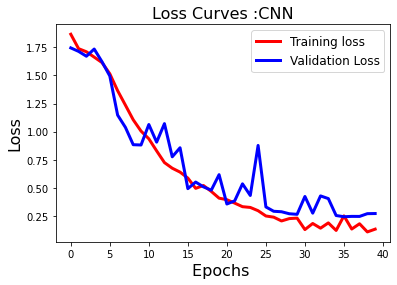

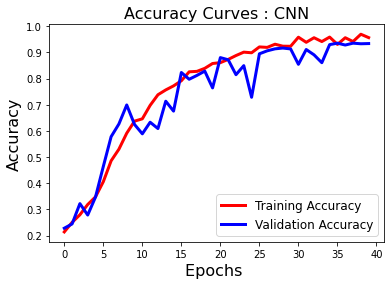

>>>END<<<


In [ ]:
for i in EPOCHS_VALUES:
    for x in BATCH_SIZES:
        for y in OPTIMIZERS_VALUES:
            test =createModel()
            test.compile (loss= 'categorical_crossentropy', optimizer= y,metrics= ['acc'])
            test.summary ()
            print ("– – – – – – – – – – –")
            print ("Epoches: {0} - Batchsize: {1} - optimizer: {2}".format (i, x, y))
            print ("– – – – – – – – – – –")
            history=test.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=i,batch_size=x,callbacks=[cp])

            #------- 'Training loss' vs 'Validation Loss' --------------------
            
            fig1 = plt.figure()
            plt.plot(history.history['loss'],'r',linewidth=3.0)
            plt.plot(history.history['val_loss'],'b',linewidth=3.0)
            plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
            plt.xlabel('Epochs ',fontsize=16)
            plt.ylabel('Loss',fontsize=16)
            plt.title('Loss Curves :CNN',fontsize=16)
            fig1.savefig('loss_cnn.png')
            plt.show()

            #-------- 'Training Accuracy' vs 'Validation Accuracy' ------------

            fig2=plt.figure()
            plt.plot(history.history['acc'],'r',linewidth=3.0)
            plt.plot(history.history['val_acc'],'b',linewidth=3.0)
            plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
            plt.xlabel('Epochs ',fontsize=16)
            plt.ylabel('Accuracy',fontsize=16)
            plt.title('Accuracy Curves : CNN',fontsize=16)
            fig2.savefig('accuracy_cnn.png')
            plt.show()


            print (">>>END<<<")
